## Devoir PHYS-F-302, année académique 2019-2020

Soit l'équation différentielle linéaire à coefficients constants:

\begin{align}
\frac{d^4 f}{dx^4}-5 \frac{d^2 f}{dx^2}+ 4f = 0\hspace{5cm} (1)
\end{align}

où $f$ est une fonction de la variable $x\in [0\ 1]$. Par ailleurs, on a les conditions aux bords suivantes:

$$
f(0)=a, f'(0)=b, f(1)=c, f'(1)=d \hspace{3cm} (2)
$$

In [12]:
import numpy as np
from matplotlib import pyplot
import numba
from numba import jit

# Paramètres
nx = 101
xmin = 0
xmax = 1

l2_target = 1e-8

dx =(xmax-xmin)/(nx-1)
x = np.linspace(xmin,xmax,nx)

f_d = np.linspace(0,1,nx)
f_0 = np.zeros(nx)
f_0[-1] = 1

#erreur en norme L2
def L2_rel_error(p, pn):
    ''' Compute the relative L2 norm of the difference
    Parameters:
    ----------
    p : array of float
        array 1
    pn: array of float
        array 2
    Returns:
    -------
    Relative L2 norm of the difference
    '''
    return np.sqrt(np.sum((p - pn)**2)/np.sum(pn**2))

### Question 1 (2 points)

Quelle est la solution générale de l'équation (1)?

<font color='blue'>
Supposons une solution de la forme $f(x)=e^{\lambda x}$ et injectons ce résultat dans l'équation différentielle. Nous obtenons alors:

\begin{align}
\frac{\partial^4}{\partial x^4} \left(e^{\lambda x}\right) - 5 \frac{\partial^2}{\partial x^2}\left(e^{\lambda x}\right) + 4\left(e^{\lambda x}\right) & = 0 \\
\lambda^4 \cdot e^{\lambda x} - 5\lambda^2 \cdot e^{\lambda x} + 4e^{\lambda x} & = 0 \\
\end{align}

Mettons en évidence notre $e^{\lambda x}$,

\begin{align}
\left(\lambda^4 - 5\lambda^2 + 4 \right) \left(e^{\lambda x}\right) & = 0
\end{align}

On rejette la solution triviale $e^{\lambda x}=0$, nous allons rechercher les solutions convergente. Ces solutions ne dépendent donc que de l'équation polynomiale $\lambda^4  - 5\lambda^2 + 4=0$. Remarquons que nous résolvons une équation caractéristique de notre EDO:

\begin{align}
& \left(\lambda^4 - 5\lambda^2 + 4 \right) & = 0\\
\iff & \left(\lambda - 2\right)\left(\lambda - 1\right)\left(\lambda + 1\right)\left(\lambda + 2\right) & = 0
\end{align}

Lambda a donc pour solutions:
\begin{align}
\lambda & = \left\{ -2, -1, 1, 2\right\}
\end{align}.


La solution générale à notre EDO devient donc

\begin{align}
f(x) & = C_1\cdot e^{-2x} + C_2\cdot e^{-x} + C_3\cdot e^{x} + C_4\cdot e^{2x}
\end{align}
<font>

### Question 2 (3 points)

Ecrire un code en python qui permet d'évaluer les constantes d'intégration de la solution générale en termes des conditions aux bords (2). Pour cette question vous pouvez vous servir de n'importe quelle routine fournie par numpy.

In [13]:
#on résout un système d'équations linéaires avec linalg
def boundaries_solve(bci,bcf,dbci,dbcf):
    a=np.array([[1,1,1,1],[np.exp(-2),np.exp(-1),np.exp(1),np.exp(2)],
                [-2,-1,1,2],[-2*np.exp(-2),-1*np.exp(-1),np.exp(1),2*np.exp(2)]])
    b=np.array([bci,bcf,dbci,dbcf])
    x=np.linalg.solve(a,b)
    return x

### Question 3 (2 points)

Que vaut la solution de l'équation (1) pour $a=0, b=0, c=1, d=-1$. Représentez cette fonction sur un graphique.

In [14]:
#on résout pour nos conditions aux bords et on utilise la forme analytique de la question 1
C1, C2, C3, C4 = boundaries_solve(0,1,0,-1)
p0 = C1*np.exp(-2*x)+C2*np.exp(-x)+C3*np.exp(x)+C4*np.exp(2*x)

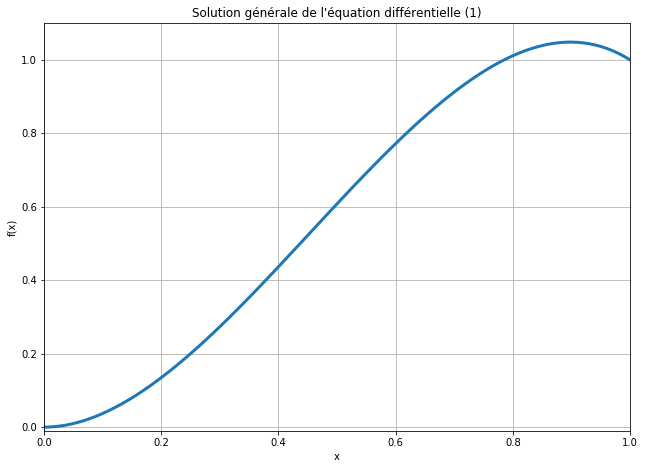

In [15]:
#--------------------------------- Graphe
pyplot.figure(figsize=(10.5,7.5))
pyplot.title('Solution générale de l\'équation différentielle (1)' )
pyplot.xlabel('x')
pyplot.ylabel('f(x)')
pyplot.plot(x, p0,
            color='C0', linestyle='-',linewidth=3)
pyplot.xlim(0,1)
pyplot.ylim(-0.01,1.1)
pyplot.grid()

### Question 4 (6 points)

Résoudre l'équation (1) avec la méthode Gauss-Seidel vue dans le cours. Combien d'itérations sont nécessaires? Comparer votre solution avec la solution obtenue à la question 3 (graphiquement et en mesurant la norme L2 de la différence).

### Question 5 (7 points)

Résoudre l'équation (1) avec la méthode du gradient conjugué vue dans le cours. Combien d'itérations sont nécessaires? Comparer votre solution avec la solution obtenue à la question 3 (graphiquement et en mesurant la norme L2 de la différence).

On commence par définir la fonction du gradient conjugué. Les conditions aux bords doivent être appliquées de la même manière que pourr Gauss-Seidel. Remarquons qu'on doit quand même le faire pour $ \vec {d} $ au risque d'avoir une réponse erronée. On essayera aussi un essai avec un array de zéros et un array qui joint $0$ à $1$ par pas de $0,1$.

In [16]:
def conjugate_gradient(p, dx, l2_target):
    
    nx= p.shape
    r  = np.zeros(nx) # On initie le residu
    Ad  = np.zeros(nx) #  et la matrice 
    
    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    #le résidu initial est calculée à partir de p.
    #Il faut initier les conditions de von Neumann pour éviter une erreur
    
    p[1] = 1/4*p[2]
    p[-2] = 1/2*(dx + 1.5 + 1/2*p[-3])
    
    
    r[2:-2] = (p[:-4] -4*p[1:-3] + 6*p[2:-2] - 4*p[3:-1] + p[4:])/dx**4 \
                        - 5*(p[1:-3] - 2*p[2:-2] + p[3:-1])/dx**2 + 4*p[2:-2]
    
    d = r.copy()    #pour la première direction, on la choisit comme exactement le résidu
    
    #condition de von Neumann pour avoir une direction correcte
    
    d[1] = 1/4*d[2]
    d[-2] = 1/2*(dx + 1.5 + 1/2*d[-3])
    
    #calcul de alpha pour établir le prochain résidu
    rho = np.sum(r*r)
    
    #produit de A et du vecteur de direction
    Ad[2:-2] = (- d[:-4] + 4*d[1:-3] - 6*d[2:-2] + 4*d[3:-1] - d[4:])/dx**4 \
                            + 5*(d[1:-3] - 2*d[2:-2] + d[3:-1])/dx**2 - 4*d[2:-2]
    
    sigma = np.sum(d*Ad)
    
    # La boucle d'itération
    while l2_norm > l2_target:
        
        #on stocke la précédente itération
        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma
        p = pk + alpha*dk
        r = rk - alpha*Ad 
        
        #on choisit la nouvelle direction 
        rhop1 = np.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        d = r + beta*dk
        
        #on calcule les conditions de von Neumann
        d[1] = 1/4*d[2]
        d[-2] = 1/2*(dx + 1.5 + 1/2*d[-3])
        
        Ad[2:-2] = (- d[:-4] + 4*d[1:-3] - 6*d[2:-2] + 4*d[3:-1] - d[4:])/dx**4 \
                                + 5*(d[1:-3] - 2*d[2:-2] + d[3:-1])/dx**2 - 4*d[2:-2]
        
        sigma = np.sum(d*Ad)
        
        #on compare le nouveau résultat et le précédent
        l2_norm = L2_rel_error(pk,p)
        iterations += 1
        l2_conv.append(l2_norm)
        
    print('Iterations nécessaire au calcul: %i' % iterations)
    return p, l2_conv

CG_0, l2_conv = conjugate_gradient(f_0, dx, l2_target)
CG_D, l2_conv = conjugate_gradient(f_d, dx, l2_target)

Iterations nécessaire au calcul: 2098
Iterations nécessaire au calcul: 1723


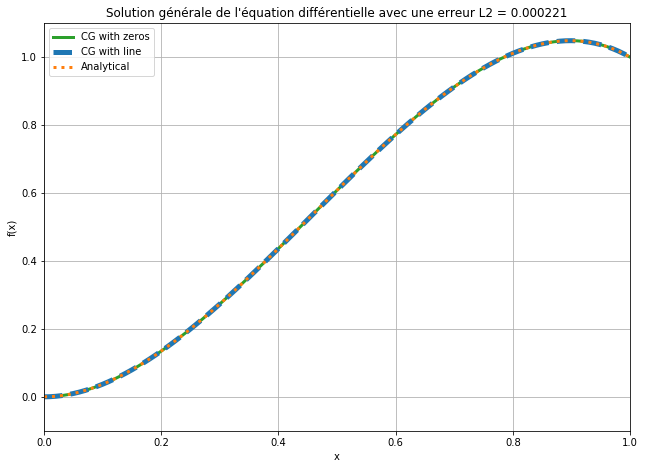

In [20]:
#on calcule l'erreur donnée par la méthode CG
err = L2_rel_error(CG,p0)

#--------------------------------- Graphe
pyplot.figure(figsize=(10.5,7.5))
pyplot.title('Solution générale de l\'équation différentielle avec une erreur L2 = %f' % err )
pyplot.xlabel('x')
pyplot.ylabel('f(x)')
pyplot.plot(x, CG_0, color='C2', linestyle='-', linewidth=3, label='CG with zeros')
pyplot.plot(x, CG_D, color='C0', linestyle='dashed', linewidth=5, label='CG with line')
pyplot.plot(x, p0, color='C1', linestyle='dotted', linewidth = 3, label='Analytical')
pyplot.legend()
pyplot.xlim(0,1)
pyplot.ylim(-0.1,1.1)
pyplot.grid()


**Conclusions:**

La méthode de Gauss-Seidel est une méthode longue nécessitant de nombreuses itérations. Elle n'est même pas si précise étant donnée le temps qu'elle prend à faire. A contrario, la méthode du gradient conjugué, même si plus fastidieuse à implémenter, est nettement plus rapide et ne requiert pas d'utiliser d'import supplémentaire comme Numba pour être efficace.
On remarquera également que le choix d'une droite comme guess initial permet une amélioration du nombre d'itérations. Par contre, CG est moins précis mais toujours plus que Gauss-Seidel dans ce cas là.
En fonction de ce qui est recherché le choix de la droite ou d'un array de zéro peuvent être considérés.